#### DCGAN 실습

#### 라이브러리 호출

In [1]:
import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

#### 1. 생성자(Generator) 및 판별자(Discriminator) 모델 정의</b>

* CNN 연산을 위하여 이미지의 크기를 1 X 32 X 32 형태로 변경하여 사용해ㅑ야한다.. (2의 거듭제곱수)

In [2]:
latent_dim = 100


# 생성자(Generator) 클래스 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = 8 # 원본 크기보다 4배 작은 값으로 초기화
        self.layer1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size * self.init_size)) # 초기 채널의 크기는 128 

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128), # 채널의 크기와 동일
            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 64로
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 1로
            nn.Tanh(),
        )

    def forward(self, z):
        output = self.layer1(z)
        output = output.view(output.size(0), 128, self.init_size, self.init_size)
        output = self.conv_blocks(output)
        return output

In [3]:
# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def make_block(in_channels, out_channels, bn=True):
            # 하나의 블록(block)을 반복할 때마다 너비와 높이는 2배씩 감소
            block = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
            block.append(nn.LeakyReLU(0.2, inplace=True))
            block.append(nn.Dropout2d(0.25))
            if bn:
                block.append(nn.BatchNorm2d(out_channels, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *make_block(1, 16, bn=False),
            *make_block(16, 32),
            *make_block(32, 64),
            *make_block(64, 128),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 2 * 2, 1),
            nn.Sigmoid()
        )

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        output = self.conv_blocks(img)
        output = output.view(output.size(0), -1)
        output = self.classifier(output)
        return output

#### <b>학습 데이터셋 불러오기</b>

* MNIST 

In [4]:
transforms_train = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### <b>모델 학습 및 샘플링</b>

* 학습을 위해 생성자와 판별자 모델 초기화시킨다.
* 그리고 적절한 하이퍼 파라미터를 설정하기

In [5]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# 생성자(generator)와 판별자(discriminator) 초기화
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 가중치(weights) 초기화
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# 손실 함수(loss function)
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# 에러발생!!!
AssertionError: Torch not compiled with CUDA enabled

코랩으로 다시 돌려본다.

* 모델을 학습하면서 주기적으로 샘플링하여 결과를 확인할 수 있따

In [6]:
import time

n_epochs = 200 # 학습의 횟수(epoch) 설정
sample_interval = 2000 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

        # 이미지 생성
        generated_imgs = generator(z)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/200] [D loss: 0.693881] [G loss: 0.673529] [Elapsed time: 29.15s]
[Epoch 1/200] [D loss: 0.682753] [G loss: 0.676904] [Elapsed time: 49.50s]
[Epoch 2/200] [D loss: 0.642572] [G loss: 0.817602] [Elapsed time: 70.08s]
[Epoch 3/200] [D loss: 0.654646] [G loss: 0.774107] [Elapsed time: 90.55s]
[Epoch 4/200] [D loss: 0.649786] [G loss: 0.940545] [Elapsed time: 111.06s]
[Epoch 5/200] [D loss: 0.618686] [G loss: 0.899241] [Elapsed time: 131.62s]
[Epoch 6/200] [D loss: 0.599695] [G loss: 0.779457] [Elapsed time: 152.68s]
[Epoch 7/200] [D loss: 0.575480] [G loss: 0.830209] [Elapsed time: 173.56s]
[Epoch 8/200] [D loss: 0.630052] [G loss: 0.885877] [Elapsed time: 194.27s]
[Epoch 9/200] [D loss: 0.552901] [G loss: 1.065834] [Elapsed time: 214.92s]
[Epoch 10/200] [D loss: 0.593423] [G loss: 0.871721] [Elapsed time: 235.97s]
[Epoch 11/200] [D loss: 0.580884] [G loss: 0.645892] [Elapsed time: 256.83s]
[Epoch 12/200] [D loss: 0.631619] [G loss: 1.153699] [Elapsed time: 277.51s]
[Epoch 13/200

예시 이미지 출력해보기

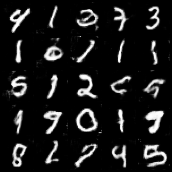

In [7]:
from IPython.display import Image

Image('92000.png')